In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Contractive Autoencoder (CAE) model
class ContractiveAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ContractiveAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Assuming input values are normalized between 0 and 1
        )

    def forward(self, x):
        # Forward pass through encoder and decoder
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Contractive loss function
def contractive_loss(recon_x, x, z, model, lambda_=1e-4):
    # Reconstruction loss (MSE)
    mse_loss = nn.MSELoss()(recon_x, x)

    # Contractive regularization term
    W = model.encoder[2].weight  # Weight matrix of the last layer in encoder
    z_grad = torch.autograd.grad(
        z, x,
        grad_outputs=torch.ones_like(z),
        create_graph=True,
        retain_graph=True
    )[0]
    jacobian_norm = torch.sum(z_grad**2)

    return mse_loss + lambda_ * jacobian_norm

# Dataset (example: MNIST-like data)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load a dataset (e.g., MNIST)
transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model, optimizer, and device setup
input_dim = 28 * 28  # MNIST images are 28x28
latent_dim = 32
model = ContractiveAutoencoder(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 10
lambda_ = 1e-4  # Regularization weight

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in data_loader:
        x, _ = batch
        x = x.view(x.size(0), -1).to(device)  # Flatten the images
        x.requires_grad = True

        optimizer.zero_grad()
        z, recon_x = model(x)
        loss = contractive_loss(recon_x, x, z, model, lambda_)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(data_loader):.4f}")


Epoch [1/10], Loss: 0.0361
Epoch [2/10], Loss: 0.0152
Epoch [3/10], Loss: 0.0118
Epoch [4/10], Loss: 0.0103
Epoch [5/10], Loss: 0.0093
Epoch [6/10], Loss: 0.0087
Epoch [7/10], Loss: 0.0083
Epoch [8/10], Loss: 0.0079
Epoch [9/10], Loss: 0.0077
Epoch [10/10], Loss: 0.0075


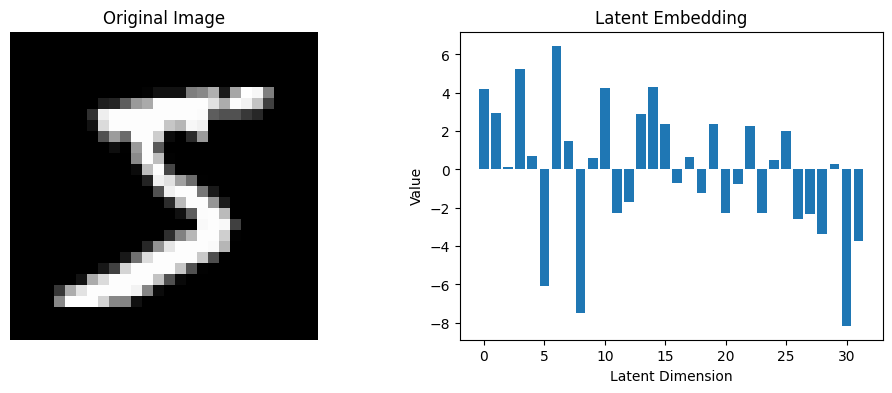

In [4]:
import matplotlib.pyplot as plt

model.eval()  # Set the model to evaluation mode

# Load a sample image from the MNIST dataset
transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
sample_image, _ = dataset[0]  # Get the first image and its label (label is ignored)
sample_image = sample_image.view(1, -1)  # Flatten the image to match input_dim

# Pass the image through the encoder to get the embedding
with torch.no_grad():
    embedding, _ = model(sample_image)

# Convert embedding to a numpy array for visualization
embedding_np = embedding.squeeze().numpy()

# Display the original image and its embedding
plt.figure(figsize=(12, 4))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image.view(28, 28), cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Show the embedding as a bar plot
plt.subplot(1, 2, 2)
plt.bar(range(len(embedding_np)), embedding_np)
plt.title("Latent Embedding")
plt.xlabel("Latent Dimension")
plt.ylabel("Value")
plt.show()

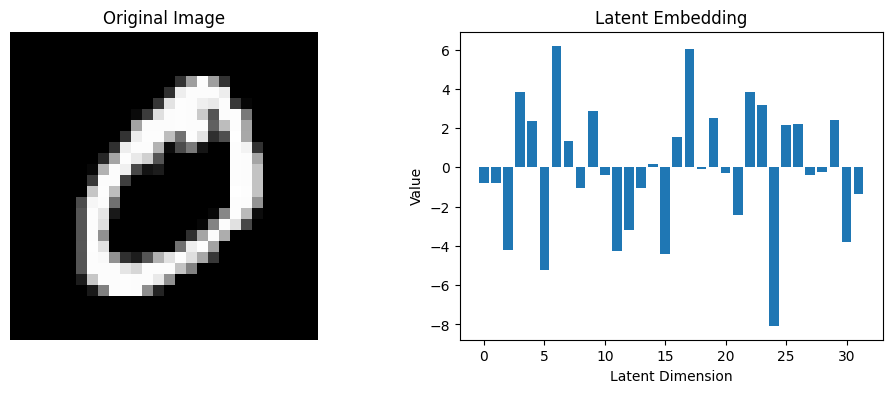

In [5]:
model.eval()  # Set the model to evaluation mode

# Load a sample image from the MNIST dataset
transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
sample_image, _ = dataset[1]  # Get the first image and its label (label is ignored)
sample_image = sample_image.view(1, -1)  # Flatten the image to match input_dim

# Pass the image through the encoder to get the embedding
with torch.no_grad():
    embedding, _ = model(sample_image)

# Convert embedding to a numpy array for visualization
embedding_np = embedding.squeeze().numpy()

# Display the original image and its embedding
plt.figure(figsize=(12, 4))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image.view(28, 28), cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Show the embedding as a bar plot
plt.subplot(1, 2, 2)
plt.bar(range(len(embedding_np)), embedding_np)
plt.title("Latent Embedding")
plt.xlabel("Latent Dimension")
plt.ylabel("Value")
plt.show()